<a href="https://colab.research.google.com/github/Sneha-mv23/PetVision/blob/main/dataset_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download Stanford Dogs image dataset
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar


--2025-07-31 04:21:18--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar.2’

images.tar.2        100%[===================>] 756.82M  25.1MB/s    in 38s     

2025-07-31 04:21:56 (20.1 MB/s) - ‘images.tar.2’ saved [793579520/793579520]



In [2]:
# Create a folder and extract images.tar
!mkdir images
!tar -xf images.tar -C images


mkdir: cannot create directory ‘images’: File exists


# New Section

In [3]:
import os, shutil, random

def split_dataset(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15):
    os.makedirs(dest_dir, exist_ok=True)
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(dest_dir, split), exist_ok=True)

    for breed in os.listdir(source_dir):
        breed_path = os.path.join(source_dir, breed)
        if not os.path.isdir(breed_path):
            continue
        images = os.listdir(breed_path)
        random.shuffle(images)

        train_end = int(len(images) * train_ratio)
        val_end = int(len(images) * (train_ratio + val_ratio))

        for i, img in enumerate(images):
            if i < train_end:
                split = 'train'
            elif i < val_end:
                split = 'val'
            else:
                split = 'test'

            dest_path = os.path.join(dest_dir, split, breed)
            os.makedirs(dest_path, exist_ok=True)

            shutil.copy(os.path.join(breed_path, img), os.path.join(dest_path, img))

# Call the function to split the dataset
split_dataset("images/Images", "data")


In [4]:
import os

for split in ['train', 'val', 'test']:
    path = os.path.join("data", split)
    total_images = sum([len(files) for r, d, files in os.walk(path)])
    print(f"{split} images: {total_images}")


train images: 20022
val images: 7960
test images: 8015


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
image_size = 224  # Standard input size for CNNs like ResNet, VGG

# For training: Resize, RandomCrop, Flip, Normalize
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# For validation and test: Resize and Normalize only
val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Define paths
train_path = 'data/train'
val_path = 'data/val'
test_path = 'data/test'

# Load datasets with transforms
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_path, transform=val_test_transforms)

batch_size = 32  # You can try 64 or 128 later

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

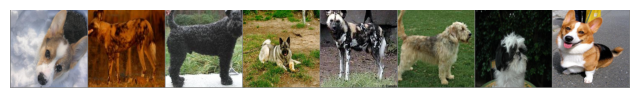

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Helper function to unnormalize and show image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get one batch from train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show 1st 8 images in the batch
imshow(torchvision.utils.make_grid(images[:8]))




In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms

class PetVisionCNN(nn.Module):
    def __init__(self, num_classes):
        super(PetVisionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B, 3, 224, 224) -> (B, 32, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # (B, 32, 112, 112)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # (B, 64, 56, 56)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                          # (B, 128, 28, 28)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                     # Flatten to (B, 128*28*28)
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    # Number of classes = number of dog breeds
num_classes = len(train_dataset.classes)

# Instantiate the model
model = PetVisionCNN(num_classes)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward + Backward + Optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f"Validation Accuracy: {val_accuracy:.2f}%")

torch.save(model.state_dict(), 'petvision_model.pth')

Epoch 1/5: 100%|██████████| 626/626 [50:01<00:00,  4.79s/it]


Epoch 1, Loss: 2994.2340, Accuracy: 1.13%


Epoch 2/5: 100%|██████████| 626/626 [52:47<00:00,  5.06s/it]


Epoch 2, Loss: 2924.9501, Accuracy: 1.71%


Epoch 3/5: 100%|██████████| 626/626 [52:48<00:00,  5.06s/it]


Epoch 3, Loss: 2830.8597, Accuracy: 2.99%


Epoch 4/5: 100%|██████████| 626/626 [52:39<00:00,  5.05s/it]


Epoch 4, Loss: 2744.6451, Accuracy: 4.40%


Epoch 5/5: 100%|██████████| 626/626 [52:26<00:00,  5.03s/it]


Epoch 5, Loss: 2616.0910, Accuracy: 6.85%
Validation Accuracy: 8.63%


In [9]:
import os

# Safer version to search all test images
sample_image_path = None

for root, dirs, files in os.walk("data/test"):
    for file in files:
        if file.endswith(".jpg"):
            sample_image_path = os.path.join(root, file)
            break
    if sample_image_path:
        break

if sample_image_path:
    print("Sample test image path:", sample_image_path)
else:
    print("No test images found. Please make sure your dataset is correctly extracted and split.")



NameError: name 'sample_image_path' is not defined

In [8]:
from PIL import Image

# Prediction function
def predict_image(image_path, model, class_names):
    model.eval()

    # Load image
    img = Image.open(image_path).convert('RGB')

    # Apply same transform as validation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    return class_names[predicted.item()]

# Load the saved model weights
model.load_state_dict(torch.load('petvision_model.pth', map_location=device))

# List of breed names from dataset
class_names = train_dataset.classes

# Example usage
image_path = '/content/data/test/n02085620-Chihuahua/n02085620_5959.jpg'  # Change this to your test image path
predicted_breed = predict_image(image_path, model, class_names)
print("Predicted Breed:", predicted_breed)


FileNotFoundError: [Errno 2] No such file or directory: '/content/data/test/n02085620-Chihuahua/n02085620_5959.jpg'